In [21]:
#!pip install pandas
#!pip install matplotlib

# Importamos librerías
import zipfile
import pandas as pd
import numpy as np
import scipy.signal as signal
from skimage.util.shape import view_as_windows
from io import BytesIO
from matplotlib import pyplot as plt
import math

In [3]:
file_path = '../DatosSinapsisArtificial'

In [4]:
def zip_to_dataframe(file_path, file_name, names):
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep = '\t', index_col = False, names = names, skiprows=range(3), decimal = ',')

### Análisis TrozoC

In [5]:
filename = 'TrozoC'
names = ['LP','VD']
trozoC = zip_to_dataframe(file_path, filename, names)

In [6]:
print('Number of channels = ', len(trozoC.columns)) # 2
print('Number of samples per channel = ', len(trozoC)) # 19847700
trozoC.head()

Number of channels =  2
Number of samples per channel =  19847700


,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471


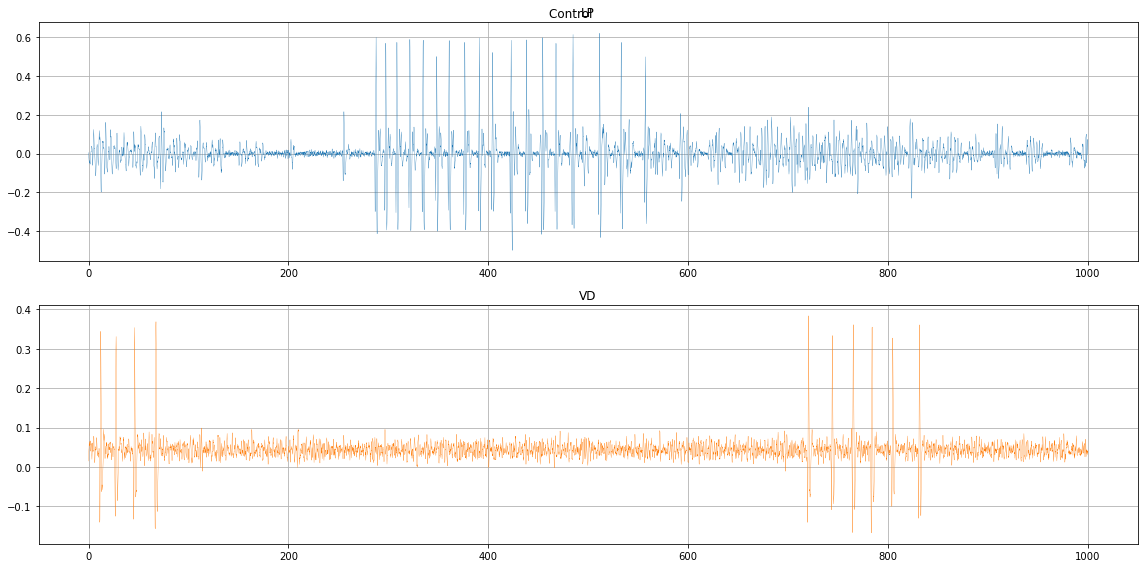

In [8]:
n = 10000
dt = 0.1
t = np.arange(0, n*dt, dt)
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control ')

ax1.grid(True)
ax1.plot(t,trozoC['LP'].iloc[:n],lw=0.3)
ax1.set_title("LP")

ax2.plot(t,trozoC['VD'].iloc[:n],'tab:orange',lw=0.3)
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

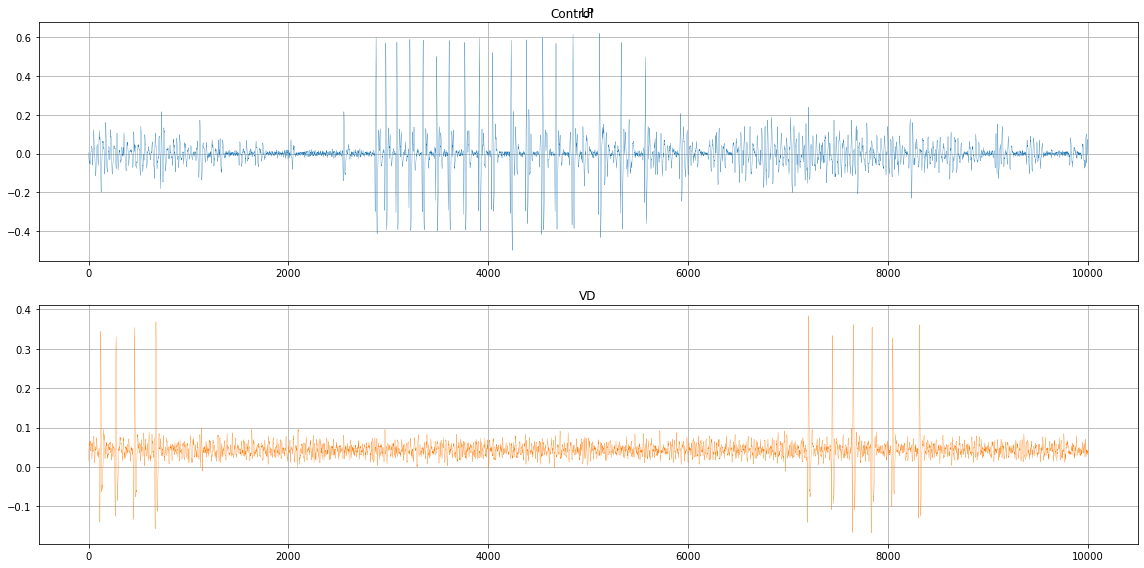

In [9]:

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control')

ax1.plot(trozoC['LP'].iloc[:n],lw=0.3)
ax1.set_title("LP")
ax1.grid(True)

ax2.plot(trozoC['VD'].iloc[:n],'tab:orange',lw=0.3)
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

Definir umbral para detectar outlier (i.e. spikes), realizar un kernel gaussiano (repasar transparencias el profe comentó algo de eso)

### Cuantización de los datos

## Detección de Spikes

### Utilizando método estadístico

In [10]:
trozoC.describe()

,LP,VD
count,1.984770e+07,1.984770e+07
mean,-2.253853e-08,4.385849e-02
std,8.214042e-02,3.287948e-02
min,-7.101440e-01,-2.170715e+00
25%,-2.288800e-02,3.295900e-02
50%,3.050000e-04,4.364000e-02
75%,2.410900e-02,5.401600e-02
max,9.344480e-01,1.351624e+00


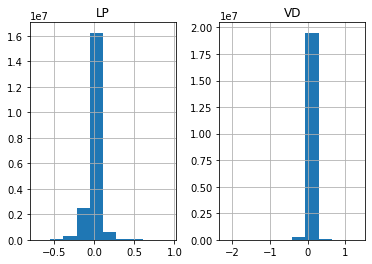

In [11]:
histogram = trozoC.hist()
plt.show()

In [38]:
def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

def get_threshold(df):
    return my_ceil(df.mean() + 4*df.std(),2)

In [39]:
threshold = get_threshold(trozoC)
threshold

LP    0.33
VD    0.18
dtype: float64

In [17]:
trozoC[:300]['LP']

0      0.004883
1      0.001526
2     -0.010681
3     -0.022278
4     -0.028076
         ...   
295   -0.081482
296   -0.086060
297   -0.072021
298   -0.053711
299   -0.033264
Name: LP, Length: 300, dtype: float64

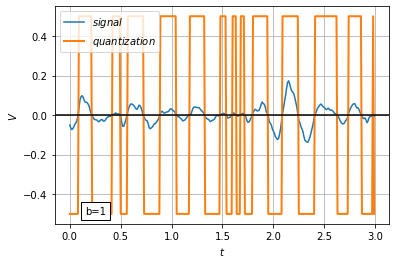

In [51]:
def levels(U, b):
    n = 2**b
    k = 2*U / n
    limits = -U + k/2 + np.arange(n)*k
    return limits

def bits_stream(digital, threshold):
    stream = digital > threshold
    return stream.astype(int)

def quantize(signal, limits):
    X = signal.reshape((-1,1))
    limits = limits.reshape((1,-1))
    dists = abs(X-limits)
    index = dists.argmin(axis=1)
    quantized = limits.flat[index]
    return quantized.reshape(signal.shape)

def plot_quantization(b, trozo):
    limits = levels(U, b)
    digital = quantize(signal, limits)

    plt.plot(t, signal, label='$signal$')
    plt.plot(t, digital, lw=2, label='$quantization$')
    plt.text(0.25, -0.5, 'b=%d' % b, ha='center', bbox=dict(facecolor='white'))
    plt.legend(fontsize=10); plt.xlabel('$t$'); plt.ylabel('$V$'); plt.grid(); plt.axhline(0, color='k')
    
    return bits_stream(digital, get_threshold(trozo))


Fs = 100
T = 3
U = 1
t = np.arange(0, T, 1/Fs)
#audio = np.array(DATA["TrozoG"]["data"].iloc[:300,0])
#signal = np.array(DATA["TrozoR"]["data"].iloc[300:600,0])
signal = np.array(trozoC.iloc[900:1200]['LP'])
plot_quantization(1, trozoC.LP)
plt.show()

In [44]:
signal = np.array(trozoC['LP'])

In [45]:
signal

array([ 0.004883,  0.001526, -0.010681, ..., -0.000916,  0.007324,
        0.004272])

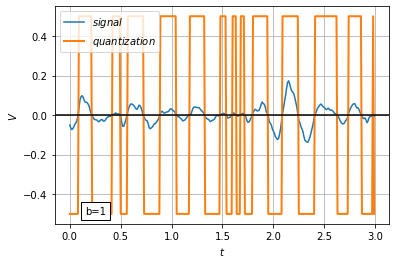

In [52]:
data = plot_quantization(1, trozoC.LP)

In [66]:
limits = levels(U, 1)
digital = quantize(signal, limits)
bits_stream(digital, get_threshold(trozoC.LP))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [8]:
def events(df, min_heights=(None, None), max_heights=(None, None), min_distance=(None, None)):
    lp_peaks, _ = signal.find_peaks(df.LP, height=(min_heights[0], max_heights[0]), distance=min_distance[0])
    vd_peaks, _ = signal.find_peaks(df.VD, height=(min_heights[1], max_heights[1]), distance=min_distance[1])
    df['s_LP'] = '0'
    df['s_VD'] = '0'
    df.loc[lp_peaks, ['s_LP']] = 1
    df.loc[vd_peaks, ['s_VD']] = 1
    return df
df = trozoC
df_d = events(df, (0.3, 0.2))
df_d

,LP,VD,s_LP,s_VD
0,0.004883,0.015259,0,0
1,0.001526,0.024109,0,0
2,-0.010681,0.031128,0,0
3,-0.022278,0.041809,0,0
4,-0.028076,0.045471,0,0
...,...,...,...,...
19847695,-0.005798,0.017395,0,0
19847696,-0.007019,0.024109,0,0
19847697,-0.000916,0.029602,0,0
19847698,0.007324,0.039368,0,0


In [9]:
df_d[df_d.s_LP == 1]

,LP,VD,s_LP,s_VD
2878,0.600891,0.041504,1,0
2975,0.570374,0.035706,1,0
3086,0.574951,0.039368,1,0
3216,0.589905,0.037231,1,0
3349,0.586243,0.039368,1,0
...,...,...,...,...
19843981,0.468140,0.044861,1,0
19844135,0.530090,0.042419,1,0
19844306,0.535583,0.066833,1,0
19844484,0.523987,0.024109,1,0


In [10]:
min_height_c = (0.4, 0.3)
max_height_c = (0.65, 0.4)
min_distance_c = (100, 95)

df_c = events(df, min_height_c, max_height_c, min_distance_c)

In [20]:
df_c[df_c.s_LP == 1]

,LP,VD,s_LP,s_VD
2878,0.600891,0.041504,1,0
3086,0.574951,0.039368,1,0
3216,0.589905,0.037231,1,0
3349,0.586243,0.039368,1,0
3484,0.501404,0.048828,1,0
...,...,...,...,...
19843981,0.468140,0.044861,1,0
19844135,0.530090,0.042419,1,0
19844306,0.535583,0.066833,1,0
19844484,0.523987,0.024109,1,0


In [18]:
top_limit = 0.3
down_limit = 0.4
df = df_d
df_short = df[:10000]
diffs_lp = np.diff(df.index[df.s_LP == "1"])
diffs_lp = diffs_lp[(diffs_lp < top_limit) & (diffs_lp > down_limit)]
diffs_vd = np.diff(df.index[df.s_VD == "1"])
diffs_vd = diffs_vd[(diffs_vd < top_limit) & (diffs_vd > down_limit)]

In [19]:
diffs_lp

array([], dtype=int64)

### Discretización

In [61]:
trozoC_d.LP[trozoC_d.LP == 1]

2877        1
2878        1
2975        1
3086        1
3087        1
           ..
19837618    1
19838419    1
19838420    1
19843869    1
19843870    1
Name: LP, Length: 32471, dtype: int64

In [55]:
def discretize(df,threshold):
    return (df>threshold).astype(int)

In [56]:
trozoC_d = discretize(trozoC,0.55)
trozoC_d

,LP,VD
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
19847695,0,0
19847696,0,0
19847697,0,0
19847698,0,0


In [34]:
# Number of spikes detected
n_spikes = trozoC_d.sum()
n_spikes

LP    32471
VD       39
dtype: int64

In [35]:
def get_spikes_index(df,column):
    return df[df[column]==1].index

In [36]:
spikes_lp_idx = get_spikes_index(trozoC_d,'LP')
spikes_vd_idx = get_spikes_index(trozoC_d,'VD')

In [37]:
len(spikes_lp_idx)

32471

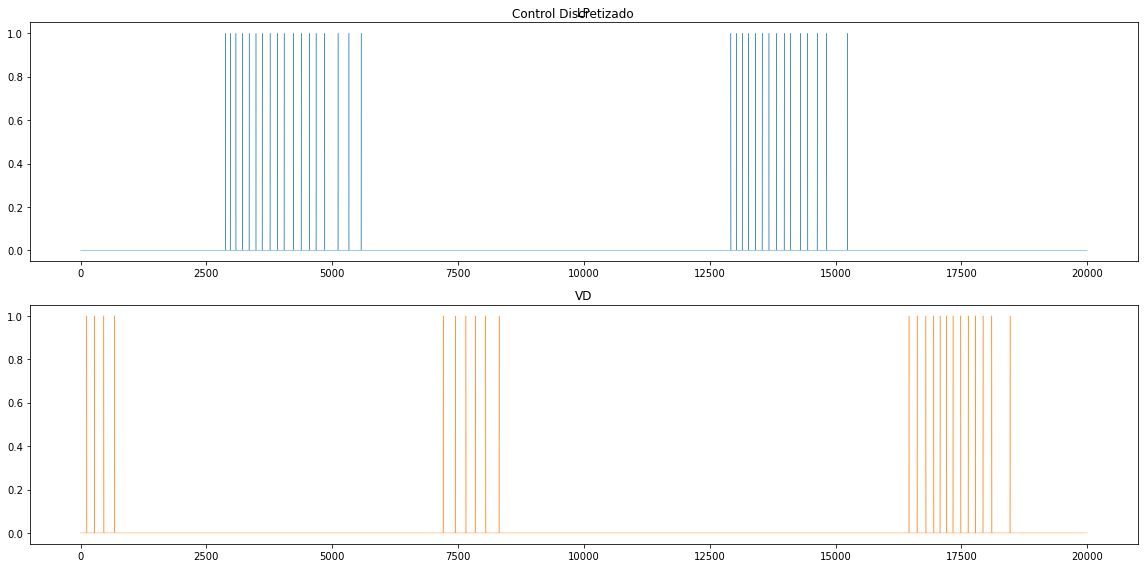

In [21]:
n = 20000

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control Discretizado')

ax1.plot(trozoC_d['LP'].iloc[:n],lw=0.4)
ax1.set_title("LP")

ax2.plot(trozoC_d['VD'].iloc[:n],'tab:orange',lw=0.4)
ax2.set_title("VD")

fig.tight_layout()

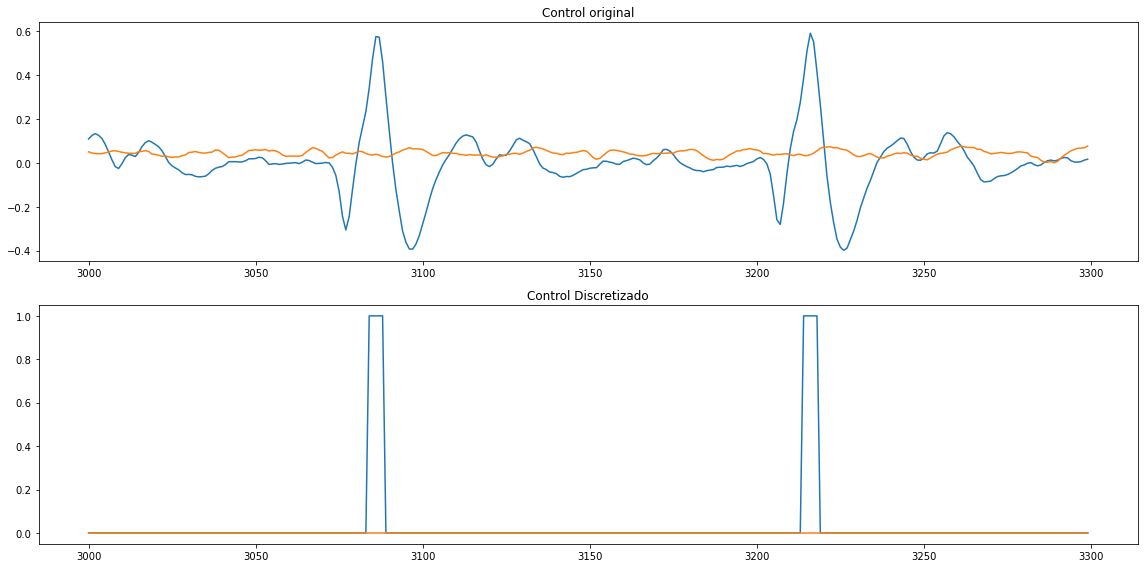

In [22]:
i = 3000
f = 3300

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(16, 8)
#fig.suptitle('Control Discretizado')

ax1.plot(trozoC['LP'].iloc[i:f])
ax1.plot(trozoC['VD'].iloc[i:f])
ax1.set_title("Control original")


ax2.plot(trozoC_d['LP'].iloc[i:f])
ax2.plot(trozoC_d['VD'].iloc[i:f],'tab:orange')
ax2.set_title("Control Discretizado")

fig.tight_layout()

## Tamaño de la ventana

In [23]:
control_lp_distances = np.diff(spikes_lp_idx)
control_vd_distances = np.diff(spikes_vd_idx)

print('Distancias MinMax entre spikes Control LP = ', np.amin(control_lp_distances),np.amax(control_lp_distances))
print('Distancias MinMax entre spikes Control VD = ', np.amin(control_vd_distances),np.amax(control_vd_distances))

Distancias MinMax entre spikes Control LP =  1 20755
Distancias MinMax entre spikes Control VD =  1 29903


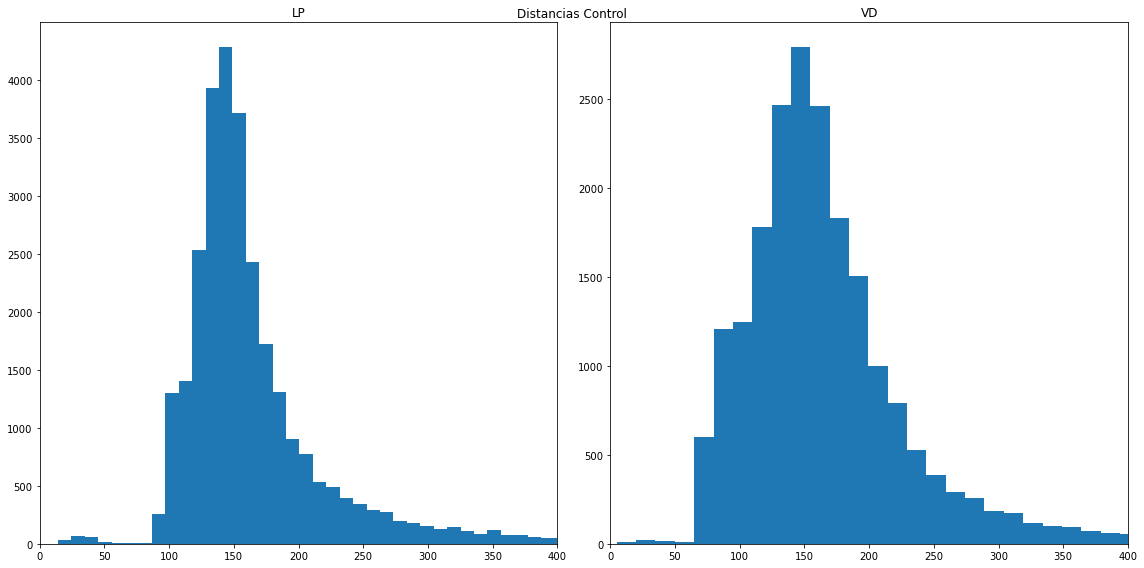

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Distancias Control')

ax1.hist(control_lp_distances,bins=2000)
ax1.set_xlim((0, 400))
ax1.set_title("LP")


ax2.hist(control_vd_distances,bins=2000)
ax2.set_title("VD")
ax2.set_xlim((0, 400))

fig.tight_layout()

In [25]:
def get_spikes_idx_corrected(series,distances):
    to_remove = np.where(distances==1)
    return np.delete(series,to_remove)

In [26]:
spikes_lp_idx = get_spikes_idx_corrected(spikes_lp_idx,control_lp_distances)
spikes_vd_idx = get_spikes_idx_corrected(spikes_vd_idx,control_vd_distances)

In [27]:
trozoC_d_c = pd.DataFrame(0, index=np.arange(len(trozoC)), columns=['LP','VD'])
trozoC_d_c['LP'][spikes_lp_idx] = 1
trozoC_d_c['VD'][spikes_vd_idx] = 1

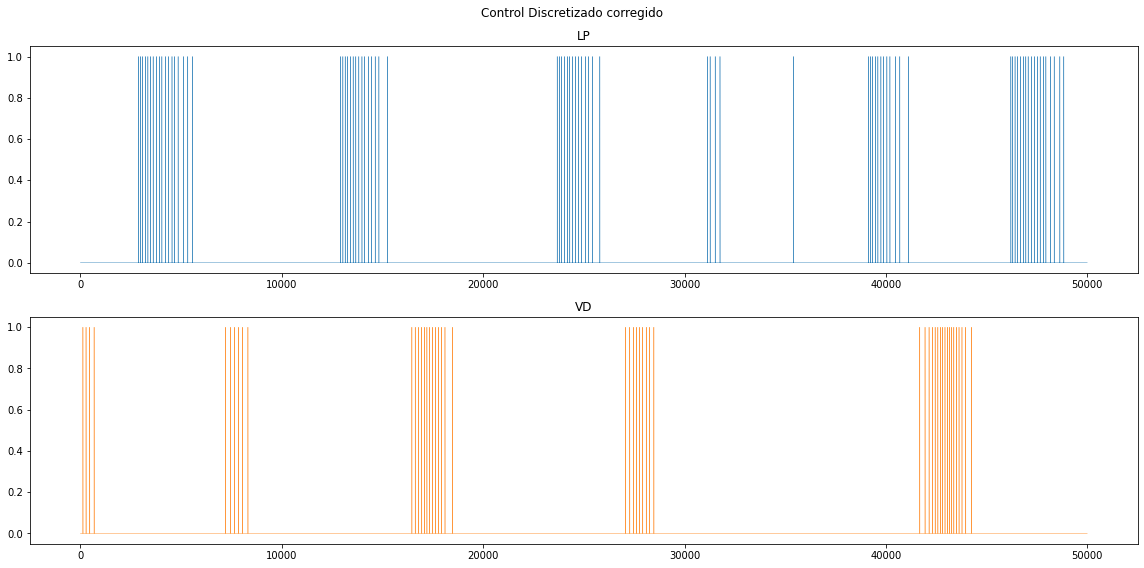

In [97]:
n = 50000

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control Discretizado corregido')

ax1.plot(trozoC_d_c['LP'].iloc[:n],lw=0.4)
ax1.set_title("LP")

ax2.plot(trozoC_d_c['VD'].iloc[:n],'tab:orange',lw=0.4)
ax2.set_title("VD")

fig.tight_layout()

In [28]:
control_lp_distances = np.diff(spikes_lp_idx)
lp_bin_size = np.amin(control_lp_distances)
print('Distancia mínima entre spike Control LP = ', lp_bin_size)


control_vd_distances = np.diff(spikes_vd_idx)
vd_bin_size = np.amin(control_vd_distances)
print('Distancia mínima entre spike Control VD = ', vd_bin_size)

Distancia mínima entre spike Control LP =  14
Distancia mínima entre spike Control VD =  5


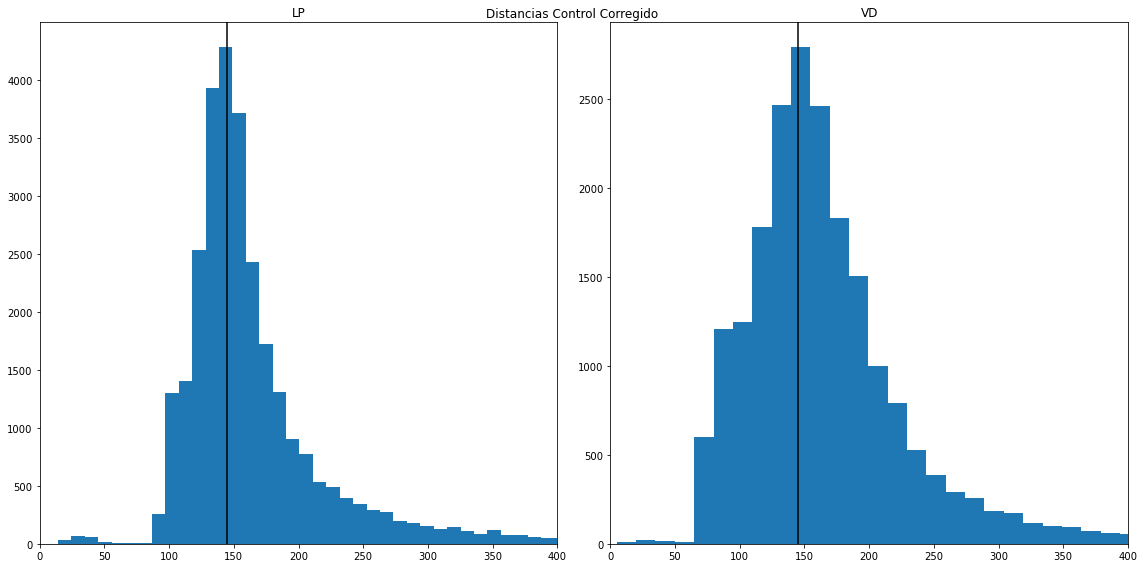

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Distancias Control Corregido')

ax1.hist(control_lp_distances,bins=2000)
ax1.axvline(x=145, color='k')
ax1.set_xlim((0, 400))
ax1.set_title("LP")

ax2.hist(control_vd_distances,bins=2000)
ax2.set_title("VD")
ax2.axvline(x=145, color='k')
ax2.set_xlim((0, 400))

fig.tight_layout()

In [ ]:
def get_errors_rate(df, n):
    A = df.groupby(df.index // n).sum()
    return A[A>1].count()

In [82]:
trozoC_d_c = pd.DataFrame(0, index=np.arange(len(trozoC)), columns=['LP','VD'])
trozoC_d_c['LP'][spikes_lp_idx] = 1
trozoC_d_c['VD'][spikes_lp_idx] = 1

In [26]:
### PROBLEMA: LA MINIMA DISTANCIA ES 14 PERO HAY QUE MIRARLO EN TRASLACIONES, HAY QUE HACER OTRO EXPERIMENTO

In [57]:
rate = [get_errors_rate(trozoC_d_c, bin_size) for bin_size in range(1,50)]

In [55]:
lp_rate= [r.LP for r in rate]

vd_rate =  [r.VD for r in rate]

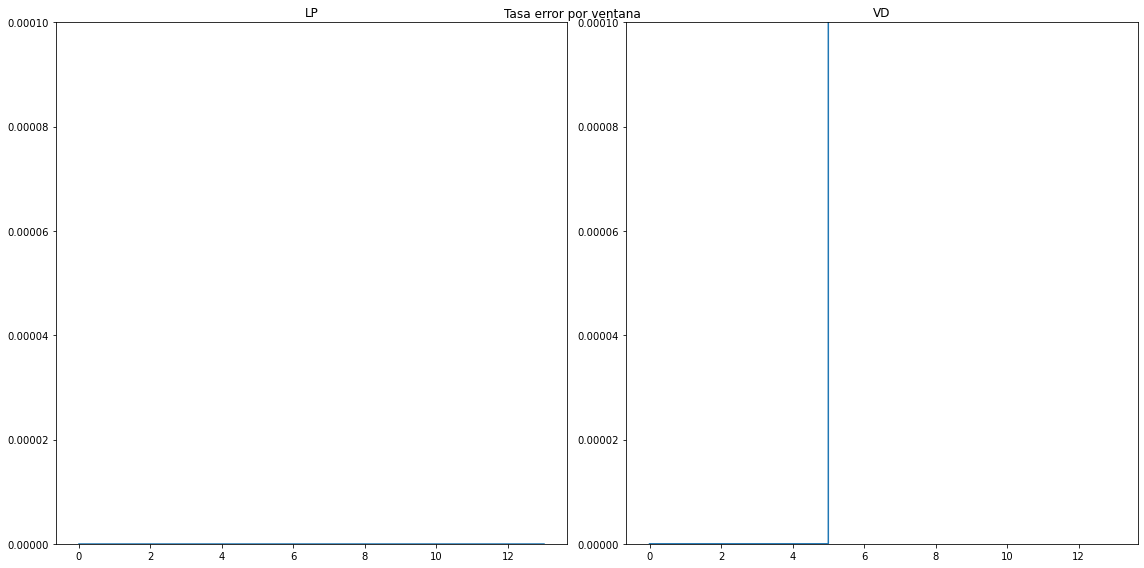

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Tasa error por ventana')

ax1.plot(lp_rate)
ax1.set_title("LP")
ax1.set_ylim((0,0.0001))


ax2.plot(vd_rate)
ax2.set_title("VD")
ax2.set_ylim((0,0.0001))


fig.tight_layout()

In [23]:
min_height_c = (0.4, 0.3)
max_height_c = (0.65, 0.4)
min_distance_c = (100, 95)

df_c = events(df, min_height_c, max_height_c, min_distance_c)

view_as_windows(df_c.s_LP,())

,LP,VD,s_LP,s_VD
0,0.004883,0.015259,0,0
1,0.001526,0.024109,0,0
2,-0.010681,0.031128,0,0
3,-0.022278,0.041809,0,0
4,-0.028076,0.045471,0,0
...,...,...,...,...
19847695,-0.005798,0.017395,0,0
19847696,-0.007019,0.024109,0,0
19847697,-0.000916,0.029602,0,0
19847698,0.007324,0.039368,0,0
